In [135]:
__author__ = 'jz-rolling'

import os, glob
import numpy as np
import tifffile
import nd2reader as nd2


class ImageLoader:

    def __init__(self, image_file=None, log=None, verbose=False):
        self.header = ''
        self.format = ''
        self.source = ''
        self.pixel_microns = 1
        self.channels = []
        self.n_channels = 1
        self.n_fields = 1
        self.n_frames = 1
        self.axes = 'PTCZYX'
        self.axes_dict = {}
        self._update_axes_dict()
        self.shape = (2048, 2048)
        self.stack_shape = ()
        self.volumes = {}
        self.external_obj = None
        self.metadata = {}
        self.log = log
        self.verbose = verbose
        if image_file is not None:
            self.read(image_file)

    def read(self, image_file):
        """
        Load image file.
        :param image_file: file path.
        :return: self.
        """
        if not os.path.isfile(image_file):
            raise ValueError('File {} not found.'.format(image_file))
        if image_file.endswith('.nd2'):
            self._softread_nd2file(image_file)
        elif image_file.endswith('.tif') or image_file.endswith('.tiff'):
            self._softread_tiffile(image_file)
        else:
            raise ValueError('.{} format not supported (yet)!'.format(image_file.split('.')[-1]))

    def get_slice(self,
                  channel=0,
                  position=0,
                  time=0,
                  zplane=0):
        """
        get image slice based on user provided specifications
        :param channel: channel index, between 0 and self.n_channels-1.
        :param position: position index, between 0 and self.n_positions-1.
        :param time: time frame index, between 0 and self.n_frames-1.
        :param zplane: Z-plane index, between 0 and self.n_zpositions-1.
        :return: single image slice which has a shape of self.shape. 
        """

        if self.format == 'tif':
            sliced_img = _get_slice_tifffile(self, self.axes, channel=channel, time=time, position=position,
                                             zplane=zplane)
        elif self.format == 'nd2':
            sliced_img = np.array(self.external_obj.get_frame_2D(c=channel, v=position, t=time, z=zplane))
        else:
            raise ValueError('Data format {} not supported (yet)!'.format(self.format))
        return sliced_img

    def _softread_tiffile(self, image_file, header=None, channels=None, pixel_microns=0.065):
        """
        open .tif file/hyperstack, current version can only handle single clips or hyperstack rendered by imagej.
        :param image_file: .tif file path
        :param header: in case you want to use a different file header
        :param channels: microscopy channel names
        :param pixel_microns: micron length per pixel
        """

        # convert .tif file to standard OMEGA input
        # only supports single view, single/multi- channel tif data
        if not isinstance(image_file, str):
            raise ValueError('Illegal input!')
        if not image_file.endswith('.tif'):
            raise ValueError('Input {} is not a .tif file.'.format(image_file.split('/')[-1]))
        if header is None:
            header = image_file.split('/')[-1].split('.')[0]

        #
        img = tifffile.TiffFile(image_file)
        series = img.series[0]

        self.format = 'tif'
        self.header = header
        self.axes = series.axes
        self._update_axes_dict()
        self.shape = (series.shape[self.axes_dict['Y']], series.shape[self.axes_dict['X']])

        if 'Info' in img.imagej_metadata:
            self.metadata = imagej_meta2dict(img.imagej_metadata['Info'])
        else:
            self.metadata = img.imagej_metadata

        # use embedded scaling factor if available
        self.pixel_microns = float(self.metadata['dCalibration']) if 'dCalibration' in self.metadata else float(
            pixel_microns)
        self.n_channels = series.shape[self.axes_dict['C']] if 'C' in self.axes else 1

        # imageJ hyperstack does not support images with multiple fields x multiple z positions
        self.n_fields = series.shape[self.axes_dict['Z']] if 'Z' in self.axes else 1
        self.n_zpositions = series.shape[self.axes_dict['Z']] if 'Z' in self.axes else 1

        # now support time frames
        self.n_frames = series.shape[self.axes_dict['T']] if 'T' in self.axes else 1
        self.stack_shape = series.shape

        if channels is not None:
            if len(channels) != self.n_channels:
                raise ValueError('{} channels found, {} channel names specified!'.format(self.n_channels, len(channels)))
            self.channels = channels
        else:
            self.channels = ['C{}'.format(i + 1) for i in range(self.n_channels)]

        self.external_obj = img

    def _softread_nd2file(self, image_file, header=None):
        """
        open .nd2 image file
        :param image_file: .nd2 file path
        :param header: in case you want to use a different file header
        """
        # convert .nd2 file to standard OMEGA input
        # img axes: v->t->c->y->x
        if not isinstance(image_file, str):
            raise ValueError('Illegal input!')
        if not image_file.endswith('.nd2'):
            raise ValueError('Input {} is not a .nd2 file.'.format(image_file.split('/')[-1]))
        if header is None:
            header = image_file.split('/')[-1].split('.')[0]
        # sorted_data = {}

        img = nd2.ND2Reader(image_file)
        sizes = img.sizes
        metadata = img.metadata
        shape = (sizes['x'], sizes['y'])
        channels = metadata['channels']
        n_channels = len(channels)
        n_fields = sizes['v'] if 'v' in sizes else 1
        n_time = sizes['t'] if 't' in sizes else 1
        n_zcoords = sizes['z'] if 'z' in sizes else 1
        self.format = 'nd2'
        self.header = header
        self.metadata = metadata
        self.pixel_microns = metadata['pixel_microns']
        self.external_obj = img
        self.channels = channels
        self.n_fields = n_fields
        self.n_channels = n_channels
        self.n_timepoints = n_time
        self.n_zpositions = n_zcoords
        self.shape = shape
        self.stack_shape = (self.n_fields, self.n_timepoints, self.n_channels,
                            self.n_zpositions, self.shape[0], self.shape[1])

    def _update_axes_dict(self):
        self.axes_dict = {x: i for i, x in enumerate(self.axes)}


def sort2folder(src_folder):
    """
    sort JOBS .nd2 files to well folders
    :param src_folder:
    :return: move .nd2 files to well folders.
    """
    files = sorted(glob.glob(src_folder + '*.nd2'))
    for f in files:
        header = f.split('/')[-1]
        well = header.split('_')[1][4:]
        subfolder = '{}{}/'.format(src_folder, well)
        if not os.path.isdir(subfolder):
            os.mkdir(subfolder)
        os.rename(f, '{}{}'.format(subfolder, header))


def imagej_meta2dict(ImageJinfo):
    """
    Extract metadata from imageJ processsed .tif files
    :param ImageJinfo: imagej converted metadata
    :return: dictionary of metadata
    """
    if "\n" in ImageJinfo:
        ImageJinfo = ImageJinfo.split("\n")
    ImageJdict = {}
    for info in ImageJinfo:
        info = info.split(" = ")
        if len(info) == 2:
            key = info[0]
            val = info[1]
            if key.startswith(" "):
                key = key[1:]
            if val.startswith(" "):
                val = val[1:]
            ImageJdict[key] = val
    return ImageJdict


def _get_slice_tifffile(img_stack, axes, position=None, time=None, zplane=None, channel=None):
    # Create a dictionary to map axes to their indices
    axes_dict = {axis: i for i, axis in enumerate(axes[:-2])}  # ignore the XY axes

    # Initialize an empty slice
    img_slice = [slice(None)] * (len(axes) - 2)  # ignore the XY axes

    # Set the slices according to the input parameters
    if position is not None and 'P' in axes_dict:
        img_slice[axes_dict['P']] = position
    if time is not None and 'T' in axes_dict:
        img_slice[axes_dict['T']] = time
    if channel is not None and 'C' in axes_dict:
        img_slice[axes_dict['C']] = channel
    if zplane is not None and 'Z' in axes_dict:  # z-plane is always considered even when not requested
        img_slice[axes_dict['Z']] = zplane

    # Calculate the number of elements before the desired slice
    flat_index = 0
    for i, slice_ in enumerate(img_slice):
        if slice_ != slice(None):
            flat_index += slice_ * np.prod(img_stack.stack_shape[i + 1:-2])  # ignore the XY axes
    # Return the index in the flattened image stack
    return img_stack.external_obj.pages[int(flat_index)].asarray()

In [128]:
#image_file = '/Users/jz-rolling/Desktop/rif_tl_driftcorrected.tif'
image_file = '/Users/jz-rolling/Desktop/namH_stationary_001.nd2'
x = ImageLoader(image_file)

In [134]:
x.channels

['TRITC', 'CFP', 'Phase_Ian']

In [133]:
%timeit m=x.get_slice(channel=2,position=2)

54.7 ms ± 708 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [126]:
x=ImageLoader()
x.read()
m=get_slice(x,'TCXY',position=3,channel=0)

TypeError: read() missing 1 required positional argument: 'image_file'

In [123]:
x.stack_shape

(12, 97, 1, 1, 926, 393)

In [98]:
get_slice(x,'TCXY',time=12,channel=1)

/Users/jz-rolling/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: unsupported operand type(s) for +=: 'int' and 'list'

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x284860dc0>)

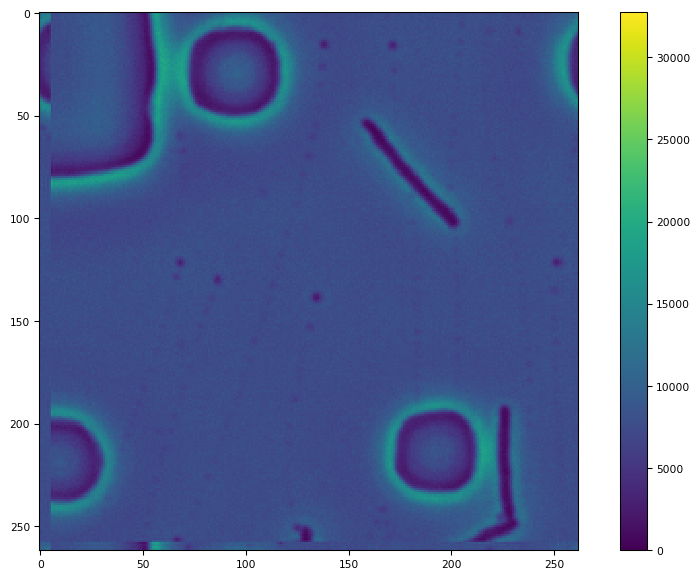

In [102]:
tifffile.imshow(x.external_obj.pages[time*x.n_channels+channel].asarray())

In [48]:
'TCZYX'

AttributeError: 

In [71]:
import nd2reader as nd2

In [46]:
x=nd2.ND2Reader('/Volumes/LaCie2/Lacie1_backup/Other_timelapse/20210722_MSR_timelapse_02/MSR_1364_3148_0389_0576_0861_001.nd2')

In [107]:
seed = np.random.seed(42)
m = np.random.random(size=[12,3,5,256,256])
m_flatten = m.reshape([12*3*5,256,256])

In [108]:
m_flatten[5]

array([[0.98432608, 0.917063  , 0.94048359, ..., 0.82996869, 0.05213705,
        0.59728529],
       [0.84874099, 0.78922081, 0.22605665, ..., 0.87860518, 0.11687728,
        0.18978905],
       [0.37028827, 0.34088014, 0.82380391, ..., 0.71082129, 0.85380762,
        0.0613948 ],
       ...,
       [0.46026037, 0.30422948, 0.35921677, ..., 0.35231369, 0.78712344,
        0.07965341],
       [0.01230819, 0.7374807 , 0.77822158, ..., 0.63840839, 0.84070791,
        0.96321379],
       [0.33165981, 0.93317238, 0.70599394, ..., 0.12371037, 0.18578356,
        0.54256988]])

In [109]:
m[0,1,0]

array([[0.98432608, 0.917063  , 0.94048359, ..., 0.82996869, 0.05213705,
        0.59728529],
       [0.84874099, 0.78922081, 0.22605665, ..., 0.87860518, 0.11687728,
        0.18978905],
       [0.37028827, 0.34088014, 0.82380391, ..., 0.71082129, 0.85380762,
        0.0613948 ],
       ...,
       [0.46026037, 0.30422948, 0.35921677, ..., 0.35231369, 0.78712344,
        0.07965341],
       [0.01230819, 0.7374807 , 0.77822158, ..., 0.63840839, 0.84070791,
        0.96321379],
       [0.33165981, 0.93317238, 0.70599394, ..., 0.12371037, 0.18578356,
        0.54256988]])